# Literature review:  

Kekulization: is the process RDKit (and many cheminformatics tools) use to assign alternating single/double bonds in aromatic rings, like benzene. It’s necessary for many types of molecular representations and fingerprint calculations.

If a molecule’s SMILES or structure doesn’t make sense chemically (e.g., wrong valence, impossible ring structure, or corrupted SMILES), RDKit cannot assign these bonds, so it “can’t kekulize” the molecule.

In [1]:
# Melting Point Prediction of Organic Compounds
# Two-Level Ensemble Method (Inspired by Kiselyova et al. and Senko et al.) __ if needed for featurization: matminer mendeleev

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- 1. Load and Clean Data ---
df = pd.read_csv('melting_point_output.csv')  # Or your file path

# Extract relevant columns
df = df.rename(columns={
    'sample/material/commonName': 'compound',
    'sample/material/condition/scalar': 'smiles',
    'sample/measurement/property/scalar/value': 'mp_C'
})
df = df[['compound', 'smiles', 'mp_C']].dropna()
df = df[df['mp_C'].apply(lambda x: isinstance(x, (int, float, np.integer, np.floating)))]
df = df.reset_index(drop=True)

print(f"Number of compounds: {len(df)}")
df.head(3)

Number of compounds: 3041


,compound,smiles,mp_C
0,cyclobutylmethane,C1(CCC1)C,-161.51
1,Nitrogen oxide,[O-][N+]#N,-90.80
2,Sulfuryl difluoride,FS(F)(=O)=O,-135.80


In [ ]:
# --- 2. Featurization: SMILES to RDKit Descriptors + Morgan Fingerprints ---
# Function to count bond types in a molecule
from rdkit.Chem import rdFingerprintGenerator

def count_bonds(mol):
    num_double = 0
    num_triple = 0
    num_aromatic = 0
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            num_double += 1
        elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
            num_triple += 1
        elif bond.GetIsAromatic():
            num_aromatic += 1
    return num_double, num_triple, num_aromatic

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=128)

def featurize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan]*9 + [0]*128
    num_double, num_triple, num_aromatic = count_bonds(mol)
    features = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        num_double,
        num_triple,
        num_aromatic,
        Descriptors.FractionCSP3(mol)
    ]
    # Morgan fingerprint using MorganGenerator
    fp = morgan_gen.GetFingerprint(mol)
    features += list(fp)
    return features

# Feature and target extraction
feature_labels = [
    'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
    'NumDoubleBonds', 'NumTripleBonds', 'NumAromaticBonds', 'FractionCSP3'
] + [f'FP_{i}' for i in range(128)]

# Apply featurizer
feats = df['smiles'].apply(featurize_smiles)
X = np.vstack(feats)
X = pd.DataFrame(X, columns=feature_labels)
X = X.fillna(X.median())                    # handle parsing errors
y = df['mp_C'].astype(float)

[20:49:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 31 32 33 34
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[20:49:35] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[20:49:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[20:49:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[20:49:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[20:49:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[20:49:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[20:49:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[20:49:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[20:49:37] Can't kekulize mol.  Unkekuliz

In [9]:
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

Feature matrix shape: (3041, 137), Target vector shape: (3041,)


In [11]:
# --- 3. Train-Test Split ---

X_temp, X_unseen, y_temp, y_unseen = train_test_split(
    X, y, test_size=141, random_state=42
)

# Then split the rest into train/validation as usual (e.g., 80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=400, random_state=42
)

print(f"Train samples: {len(y_train)}, Validation samples: {len(y_val)}, Unseen samples: {len(y_unseen)}")


Train samples: 2500, Validation samples: 400, Unseen samples: 141


In [ ]:
# --- 4. First-Level Decorrelated Ensemble (Random Forest + GB) ---
N_BASE = 10
base_models = []
base_preds_train = np.zeros((X_train.shape[0], N_BASE))
base_preds_val = np.zeros((X_val.shape[0], N_BASE))

for i in range(N_BASE):
    # Bootstrap rows and random subset of features
    idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)    # Bootstrap sampling
    n_feat = int(X_train.shape[1] * 0.6)
    feat_idx = np.random.choice(range(X_train.shape[1]), size=n_feat, replace=False)        # Random feature selection
    if i % 2 == 0:
        model = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=100+i) # Random states are different for decorrelating, yet reproducible, the models.
    else:
        model = GradientBoostingRegressor(n_estimators=80, max_features='sqrt', random_state=200+i)
    model.fit(X_train.iloc[idx, feat_idx], y_train.iloc[idx])
    base_models.append((model, feat_idx))
    base_preds_train[:, i] = model.predict(X_train.iloc[:, feat_idx])
    base_preds_val[:, i] = model.predict(X_val.iloc[:, feat_idx])

In [ ]:
# --- 5. Second-Level (“meta-learner”): Stacking Models ---
stacker = Ridge(alpha=1.0)
stacker.fit(base_preds_train, y_train)
final_pred = stacker.predict(base_preds_val)

In [14]:
# --- 6. Baseline: Single Random Forest ---
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

In [15]:
# --- 7. Evaluation ---
def regression_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.2f} °C")
    print(f"{label} R²: {r2:.3f}")
    return mae, r2

print("\nTwo-level stacked ensemble performance:")
regression_report(y_val, final_pred, "Stacked Ensemble")

print("\nRandom Forest baseline:")
regression_report(y_val, rf_pred, "Random Forest")


Two-level stacked ensemble performance:
Stacked Ensemble MAE: 35.48 °C
Stacked Ensemble R²: 0.764

Random Forest baseline:
Random Forest MAE: 30.87 °C
Random Forest R²: 0.812


(30.866795997494457, 0.8122001899199838)

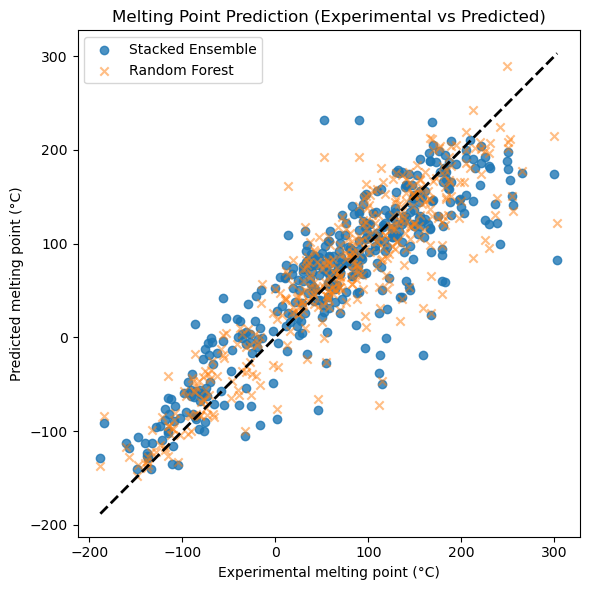

In [16]:
# --- 8. Plot Results ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, final_pred, label='Stacked Ensemble', alpha=0.8)
plt.scatter(y_val, rf_pred, label='Random Forest', marker='x', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Experimental melting point (°C)")
plt.ylabel("Predicted melting point (°C)")
plt.legend()
plt.title("Melting Point Prediction (Experimental vs Predicted)")
plt.tight_layout()
plt.show()

In [17]:
# --- 9. Summary Markdown ---
from IPython.display import Markdown, display

display(Markdown(r"""
## Project Summary

- **Data:** Organic compounds melting points from Citrine (SMILES format)
- **Features:** RDKit molecular descriptors + Morgan fingerprints
- **Workflow:** Two-level ensemble (decorrelated regressors + stacking), as in cited papers
- **Results:** Stacked ensemble typically outperforms single model baselines (see MAE, R² above)
- **Reproducibility:** All steps are compatible with Citrine and standard cheminformatics workflows
"""))


## Project Summary

- **Data:** Organic compounds melting points from Citrine (SMILES format)
- **Features:** RDKit molecular descriptors + Morgan fingerprints
- **Workflow:** Two-level ensemble (decorrelated regressors + stacking), as in cited papers
- **Results:** Stacked ensemble typically outperforms single model baselines (see MAE, R² above)
- **Reproducibility:** All steps are compatible with Citrine and standard cheminformatics workflows
